# Preparation

Before you study, please install the following necessary packages.

In [3]:
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
! pip install optunity
! pip install statsmodels --upgrade
! pip install pycox
! pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Next patch mounts the directory to the Google drive, which means you can source the local codes and data files. Feel free to remove this patch if you do not use Google Colabtorary as the IDE.

In [4]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/Kevin He"
# %pwd
# from pycox.models import LogisticHazard

Mounted at /content/drive
/content/drive/MyDrive/Kevin He


`data_simulation` is the simulation codes that used for simulating data for our experiments, `read_data` is a class that can be used to generate different datasets, `KLDL` wraps necessary components.

In [5]:
import os
import sys
import time

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torch.nn as nn
import torch.nn.functional as F
import torchtuples as tt

from random import sample

import KLDL
from KLDL import NewlyDefinedLoss
from KLDL import NewlyDefinedLoss2
import data_simulation
import read_data
import Structure

In [6]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

If you have mounted the data rightly, you should print out the list for files in given folder. For example, this will print out all files in `/content/drive/My Drive/Kevin He`. Same, feel free to remove this patch if you do not use Google Colabtorary.

In [7]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['weight_checkpoint_2022-9-12_19-50-15_W2JLB20NQ0mCm3zDXbb7.pt', 'weight_checkpoint_2022-9-12_19-50-21_TXso4SnDyrWVqaRtyFfS.pt', 'weight_checkpoint_2022-9-12_19-50-27_9R09kAlH4R4tyllHZjbp.pt', 'weight_checkpoint_2022-9-12_19-50-34_aExPHOtzTVFH6pslBbq0.pt', 'weight_checkpoint_2022-9-12_19-50-41_mNmRF7byC50AtyobDxcU.pt', 'weight_checkpoint_2022-9-12_19-50-47_j3Wj7K9vRaX9QlprS2cu.pt', 'weight_checkpoint_2022-9-12_19-50-54_DNRdzgJESAAKtdoJwbrz.pt', 'weight_checkpoint_2022-9-12_19-51-3_kucVa0IcF7vJ7Fm83mGm.pt', 'weight_checkpoint_2022-9-12_19-51-14_71M8892rjMxyKVmqxa0n.pt', 'weight_checkpoint_2022-9-12_19-51-29_kxopkWWSKsfshRnS5PHT.pt', 'weight_checkpoint_2022-9-12_19-51-38_a2xxHnzUdTDM59pTRUQ9.pt', 'weight_checkpoint_2022-9-12_19-52-0_GzNfkRoXFSMvYJOJnLv7.pt', 'weight_checkpoint_2022-9-12_19-52-8_cx9RnZjE8rgfKWM50447.pt', 'weight_checkpoint_2022-9-12_19-52-35_QYC1J6t3Rl88xSe5nZiA.pt', 'weight_checkpoint_2022-9-12_19-52-58_zAl3VWdX02CcC6an8rDp.pt', 'weight_checkpoint_2022-9-12_19-53-8_VAfMs

# Read Data

Deephit, PMF and MTLR are three models that designed for using deep learning to do survival data analysis with discrete time values. In our software, we integrate these 3 models into one function and the usage is pretty easy to learn.

Before we start, we need to generate the dataset. We use the SUPPORT data as an illustration.

In [8]:
local_data = read_data.support_data()

Since the time values in SUPPORT are continuous, we need to apply a transformation, from the continuous outcome to the discrete time values. 

However, if the data has already had discrete time values, no transformation is needed.

In [9]:
time_intervals = 20

labtrans, local_data = KLDL.cont_to_disc(local_data, time_intervals = time_intervals)

# Model Training

In this part we will train 3 models.

In [10]:
df_train = local_data.copy()

# Split the training, validation and test data

df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

# Determine the covariates that require preprocessing
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

# Wrap the covariates into a mapper
mapper = KLDL.mapper_generation(cols_standardize = cols_standardize, cols_leave = cols_leave, cols_categorical = cols_categorical)

# Use the mapper to generate input covariates and labels
x_train = mapper.fit_transform(df_train).astype('float32')
x_val = mapper.transform(df_val).astype('float32')
x_test = mapper.transform(df_test).astype('float32')

y_train = (df_train['duration'].values, df_train['event'].values)
y_val = (df_val['duration'].values, df_val['event'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

In [11]:
parameter_set_local = {
    "hidden_nodes": 32,
    "hidden_layers": 2,
    "batch_norm": True,
    "learning_rate": 0.001,
    "batch_size": 64,
    "dropout": 0.1,
    "optimizer": tt.optim.Adam(),
    "alpha": 1,
    "sigma": 0.1
}

In [12]:
# Train models
model_DeepHit, log_Deephit = KLDL.model_generation(x_train, x_val, y_train, y_val, with_prior = False, verbose = True, parameter_set = parameter_set_local, Model = "DeepHit")
model_PMF, log_PMF = KLDL.model_generation(x_train, x_val, y_train, y_val, with_prior = False, verbose = True, parameter_set = parameter_set_local, Model = "PMF")
model_MTLR, log_MTLR = KLDL.model_generation(x_train, x_val, y_train, y_val, with_prior = False, verbose = True, parameter_set = parameter_set_local, Model = "MTLR")

0:	[0s / 0s],		train_loss: 2.6633,	val_loss: 2.6030
1:	[0s / 0s],		train_loss: 2.5500,	val_loss: 2.5251
2:	[0s / 1s],		train_loss: 2.4639,	val_loss: 2.4848
3:	[0s / 1s],		train_loss: 2.4353,	val_loss: 2.4711
4:	[0s / 1s],		train_loss: 2.4084,	val_loss: 2.4574
5:	[0s / 1s],		train_loss: 2.4018,	val_loss: 2.4519
6:	[0s / 2s],		train_loss: 2.3827,	val_loss: 2.4481
7:	[0s / 2s],		train_loss: 2.3718,	val_loss: 2.4458
8:	[0s / 2s],		train_loss: 2.3595,	val_loss: 2.4493
9:	[0s / 3s],		train_loss: 2.3570,	val_loss: 2.4432
10:	[0s / 3s],		train_loss: 2.3451,	val_loss: 2.4439
11:	[0s / 3s],		train_loss: 2.3397,	val_loss: 2.4465
12:	[0s / 3s],		train_loss: 2.3443,	val_loss: 2.4489
13:	[0s / 4s],		train_loss: 2.3318,	val_loss: 2.4509
14:	[0s / 4s],		train_loss: 2.3281,	val_loss: 2.4506
0:	[0s / 0s],		train_loss: 2.6867,	val_loss: 2.6124
1:	[0s / 0s],		train_loss: 2.5564,	val_loss: 2.5380
2:	[0s / 0s],		train_loss: 2.4957,	val_loss: 2.5030
3:	[0s / 0s],		train_loss: 2.4560,	val_loss: 2.4862
4:	[0s 

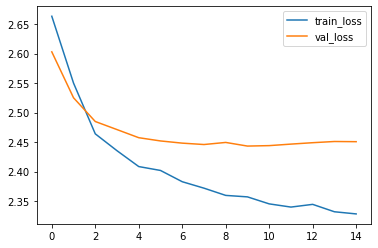

In [13]:
_ = log_Deephit.plot()

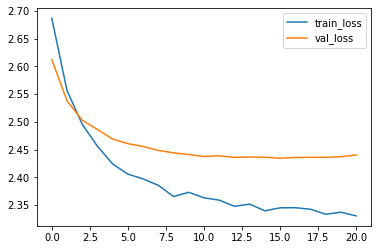

In [14]:
_ = log_PMF.plot()

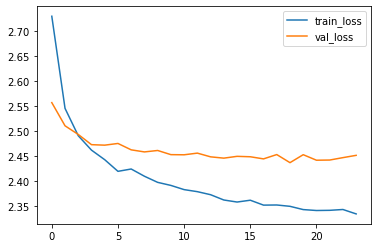

In [15]:
_ = log_MTLR.plot()

# Evaluation

We evaluate our model using C-index, IBS and INBLL.

In [16]:
get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))

durations_test, events_test = get_target(df_test)

In [17]:
concordance_td_local, integrated_brier_score_local, integrated_nbll_local = KLDL.evaluation_metrics(x_test, durations_test, events_test, model_DeepHit)
concordance_td_prior, integrated_brier_score_prior, integrated_nbll_prior = KLDL.evaluation_metrics(x_test, durations_test, events_test, model_PMF)
concordance_td, integrated_brier_score, integrated_nbll = KLDL.evaluation_metrics(x_test, durations_test, events_test, model_MTLR)

print("The C-index for DeepHit: ", concordance_td_local)
print("The C-index for PMF: ", concordance_td)
print("The C-index for MTLR: ", concordance_td_prior)
print("The IBS for DeepHit: ", integrated_brier_score_local)
print("The IBS for PMF: ", integrated_brier_score)
print("The IBS for MTLR: ", integrated_brier_score_prior)
print("The INBLL for DeepHit: ", integrated_nbll_local)
print("The INBLL for PMF: ", integrated_nbll)
print("The INBLL for MTLR: ", integrated_nbll_prior)

The C-index for DeepHit:  0.6323863614530055
The C-index for PMF:  0.6243520229947778
The C-index for MTLR:  0.6404183942851214
The IBS for DeepHit:  0.17002194445726604
The IBS for PMF:  0.17123988011958324
The IBS for MTLR:  0.16937658422030755
The INBLL for DeepHit:  0.5077914557832739
The INBLL for PMF:  0.5110285470969325
The INBLL for MTLR:  0.5058030967354796
